In [ ]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import utils

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [12, 6]
TICKER = "AAPL"
WINDOW_SIZE = 20
LOOKBACK = 10

file_path = "sp500_data.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "shannanl/sp500-dataset",
  file_path,
)
df.rename(columns={df.columns[0]: "day"}, inplace=True)

df_raw = utils.load_comp_data(df, TICKER)

# Feature Engineering ---
df_fe = utils.compute_features(df_raw, w=WINDOW_SIZE, cut=True)

raw_prices = df_raw[['timestep', f'{TICKER}_close', f'{TICKER}_high']].copy()
raw_prices.rename(columns={f'{TICKER}_close': 'close_raw', f'{TICKER}_high': 'high_raw'}, inplace=True)

df_dataset = df_fe.merge(raw_prices, on='timestep', how='inner')


/tmp/ipython-input-1899106844.py:23: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'sp500-dataset' dataset.


/content/utils.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result.fillna(method='ffill', inplace=True)


In [ ]:
def create_sequences(data_X, data_y, data_prices, lookback=10):
    X, y, base_prices = [], [], []
    for i in range(len(data_X) - lookback):
        X.append(data_X[i : i + lookback])
        y.append(data_y[i + lookback])
        base_prices.append(data_prices[i + lookback])
    return np.array(X), np.array(y), np.array(base_prices)

feature_cols = [c for c in df_fe.columns if c not in ['timestep', 'log_next_day_max_return']]
data_X_vals = df_dataset[feature_cols].values
data_y_vals = df_dataset['log_next_day_max_return'].values

data_close_raw = df_dataset['close_raw'].values

X, y, close_prices_raw = create_sequences(data_X_vals, data_y_vals, data_close_raw, lookback=LOOKBACK)

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
prices_train, prices_test = close_prices_raw[:split_idx], close_prices_raw[split_idx:]

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (4360, 10, 29)
Test shape: (1091, 10, 29)


In [ ]:
# Modelo LSTM
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=64, return_sequences=True, kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.3))
model.add(LSTM(units=32, return_sequences=False, kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(1)) # Salida lineal (predicción del log return)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stopping],
    shuffle=False
)

Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0270 - val_loss: 0.0132
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0150 - val_loss: 0.0115
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0125 - val_loss: 0.0099
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0107 - val_loss: 0.0085
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0093 - val_loss: 0.0072
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0080 - val_loss: 0.0062
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0069 - val_loss: 0.0053
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0061 - val_loss: 0.0046
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0054 - val_loss: 0.0040
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 11/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 12/100
123/123 ━━━━━━━━━

In [ ]:
y_pred = model.predict(X_test).flatten()

pred_high_prices = prices_test * np.exp(y_pred)
real_high_prices = prices_test * np.exp(y_test)

mae_price = mean_absolute_error(real_high_prices, pred_high_prices)
rmse_price = np.sqrt(mean_squared_error(real_high_prices, pred_high_prices))
r2_price = r2_score(real_high_prices, pred_high_prices)

print(f"\n--- Resultados Finales ({TICKER}) ---")
print(f"R² (Precios): {r2_price:.4f}")
print(f"MAE (Precios): ${mae_price:.2f}")
print(f"RMSE (Precios): ${rmse_price:.2f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

--- Resultados Finales (AAPL) ---
R² (Precios): 0.9989
MAE (Precios): $0.78
RMSE (Precios): $1.26


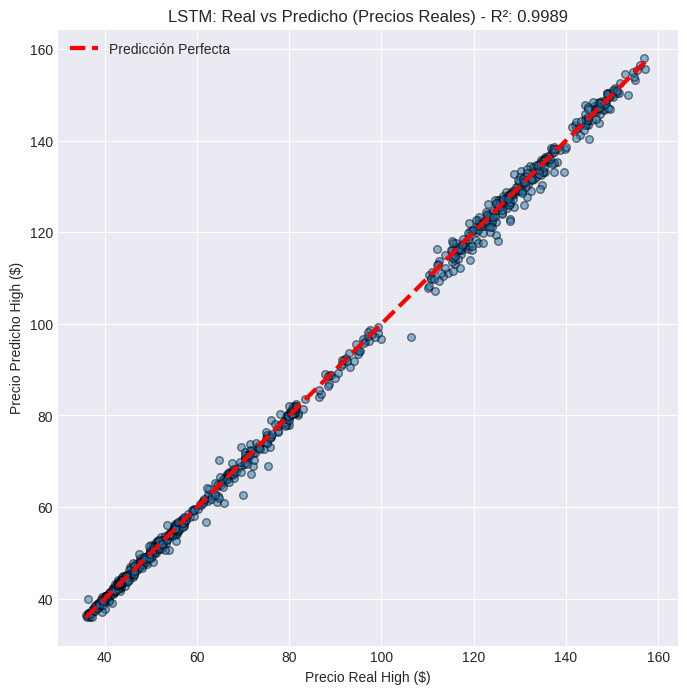

In [ ]:
fig, ax = plt.subplots(figsize=[8, 8])
ax.scatter(real_high_prices, pred_high_prices, alpha=0.5, edgecolors='k', s=30)

min_val = min(real_high_prices.min(), pred_high_prices.min())
max_val = max(real_high_prices.max(), pred_high_prices.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=3, label='Predicción Perfecta')

ax.set_xlabel('Precio Real High ($)')
ax.set_ylabel('Precio Predicho High ($)')
ax.set_title(f'LSTM: Real vs Predicho (Precios Reales) - R²: {r2_price:.4f}')
plt.legend()
plt.show()

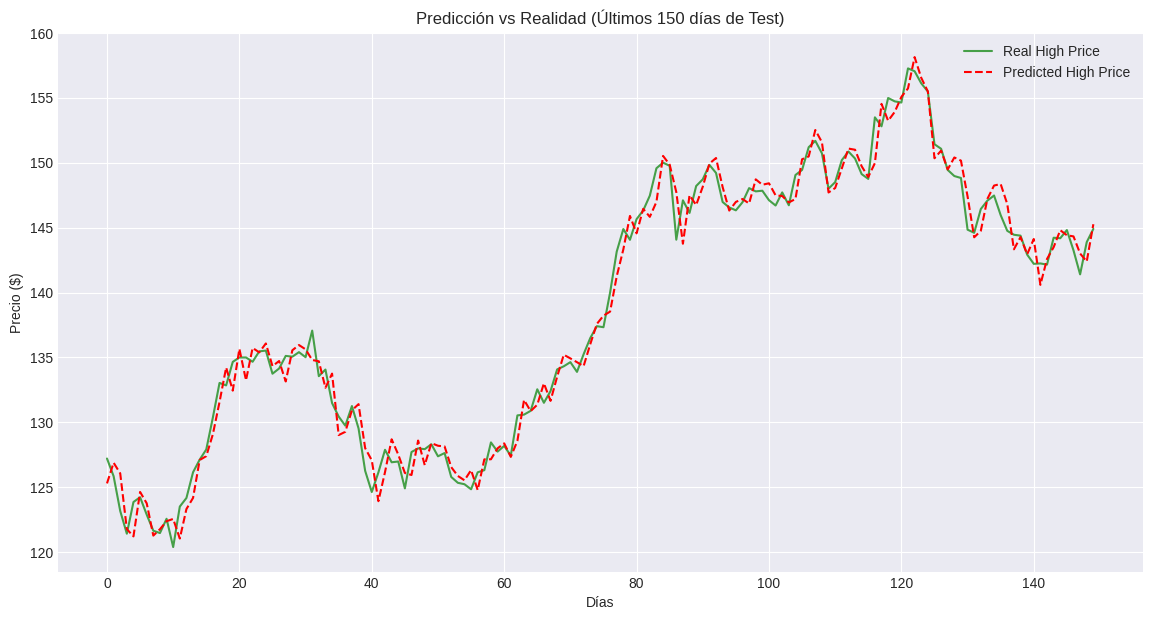

In [ ]:
subset_n = 150
plt.figure(figsize=(14, 7))
plt.plot(real_high_prices[-subset_n:], label='Real High Price', color='green', alpha=0.7)
plt.plot(pred_high_prices[-subset_n:], label='Predicted High Price', color='red', linestyle='--')
plt.title(f'Predicción vs Realidad (Últimos {subset_n} días de Test)')
plt.xlabel('Días')
plt.ylabel('Precio ($)')
plt.legend()
plt.show()

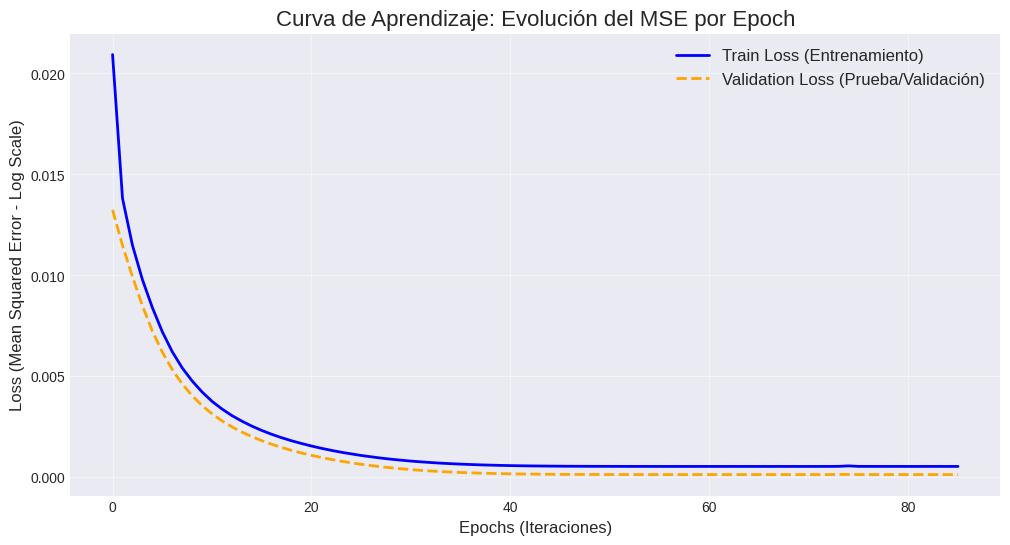


--- MÉTRICAS EN ESCALA LOGARÍTMICA (RETORNOS) ---
MSE (Error Cuadrático Medio):  0.000237
MAE (Error Absoluto Medio):    0.010129
R² (Coeficiente de Determinación): -0.0122



In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(history.history['loss'], label='Train Loss (Entrenamiento)', color='blue', linewidth=2)

if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss (Prueba/Validación)', color='orange', linestyle='--', linewidth=2)

plt.title('Curva de Aprendizaje: Evolución del MSE por Epoch', fontsize=16)
plt.xlabel('Epochs (Iteraciones)', fontsize=12)
plt.ylabel('Loss (Mean Squared Error - Log Scale)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.5)

plt.show()

y_pred = model.predict(X_test, verbose=0)

y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

print("\n" + "="*40)
print("--- MÉTRICAS EN ESCALA LOGARÍTMICA (RETORNOS) ---")
print("="*40)
print(f"MSE (Error Cuadrático Medio):  {mean_squared_error(y_test_flat, y_pred_flat):.6f}")
print(f"MAE (Error Absoluto Medio):    {mean_absolute_error(y_test_flat, y_pred_flat):.6f}")
print(f"R² (Coeficiente de Determinación): {r2_score(y_test_flat, y_pred_flat):.4f}")
print("="*40 + "\n")